# Importing all libraries

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from tqdm import tqdm
import os
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from prettytable import PrettyTable
import csv
import math
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS 

## Reading Data

In [2]:
# https://github.com/pandas-dev/pandas/issues/11493
# https://stackoverflow.com/questions/52105659/pandas-read-csv-unexpected-end-of-data-error

project_data = pd.read_csv('train_data.csv', engine='python', error_bad_lines=False)
resource_data = pd.read_csv('resources.csv', engine='python', error_bad_lines=False)

## Combining both data frames

In [3]:
'''https://stackoverflow.com/questions/43297589/merge-two-data-
frames-based-on-common-column-values-in-pandas'''
project_data = pd.merge(project_data, resource_data, on='id')

## Preprocessing data

### Preprocessing project_submitted_datetime column

In [4]:
# https://stackoverflow.com/a/2582163/4084039
cols = ['Date' if x=='project_submitted_datetime' else x for x in list(project_data.columns)]

# https://stackoverflow.com/a/49702492/4084039
project_data['Date'] = pd.to_datetime(project_data['project_submitted_datetime'])
project_data.drop('project_submitted_datetime', axis = 'columns', inplace=True)
project_data.sort_values(by=['Date'], inplace=True)

# https://stackoverflow.com/a/13148611/4084039
project_data = project_data[cols]

In [5]:
# consider we have text like this "Math & Science, Warmth, Care & Hunger"
# it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
# this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
# if we have the words "The" we are going to replace it with ''(i.e removing 'The')
# we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
#" abc ".strip() will return "abc", remove the trailing spaces
# we are replacing the & value into _

def preprocess(param1):
    lst=list()
    for i in param1:
        temp=''
        for j in i.split(','):
            if 'The' in j.split():
                j=j.replace('The', '')
            j=j.replace(' ', '')
            j=j.lower()
            temp+=j.strip()+ ' '
            temp = temp.replace('&', '_')
        lst.append(temp.strip())
    return lst

### Preprocessing of project_subject_categories

In [9]:
# https://stackoverflow.com/a/47301924/4084039
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python


categories = list(project_data['project_subject_categories'].values)

project_data['clean_categories'] = preprocess(categories)
project_data.drop(['project_subject_categories'], axis='columns', inplace=True)



cnt = Counter()
for word in project_data['clean_categories'].values:
    cnt.update(word.split())

cat_dict = dict(cnt)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv:kv[1]))
        

### Preprocessing of project_subject_subcategories

In [12]:
# https://stackoverflow.com/a/47301924/4084039
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python


sub_categories = list(project_data['project_subject_subcategories'].values)

project_data['clean_subcategories'] = preprocess(sub_categories)
project_data.drop(['project_subject_subcategories'], axis='columns', inplace=True)



cnt = Counter()
for word in project_data['clean_subcategories'].values:
    cnt.update(word.split())

sub_cat_dict = dict(cnt)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv:kv[1]))
        

### Preprocessing teacher_prefix column

In [8]:
project_data['teacher_prefix'] = project_data['teacher_prefix'].fillna("")
teacher_pfx = list(project_data['teacher_prefix'].values)

teacher_pfx_list = []
for i in teacher_pfx:
    temp = ""
    for j in i.split(','):
        if 'The' in j.split():
            j=j.replace('The', '')
        j = j.replace('.','')
        j = j.lower()
        temp +=j.strip()+" "
    teacher_pfx_list.append(temp.strip()) 
    
project_data['clean_teacher_prefix'] = teacher_pfx_list
project_data.drop(['teacher_prefix'], axis=1, inplace=True)

# count of all the words in corpus
my_counter = Counter()
for word in project_data['clean_teacher_prefix'].values:
    my_counter.update(word.split())

teacher_prefix_dict = dict(my_counter)
sorted_teacher_prefix_dict = dict(sorted(teacher_prefix_dict.items(), key=lambda kv:kv[1]))


### Preprocessing project_grade_category column

In [9]:
prj_grd_cat = list(project_data['project_grade_category'].values)

prj_grd_cat_list = []
for i in prj_grd_cat:
    temp = ""
    for j in i.split(','):
        if 'The' in j.split():
            j=j.replace('The', '')
        j = j.replace(' ','_')
        j = j.replace('-','_')
        j = j.lower()
        temp +=j.strip()+" "
    prj_grd_cat_list.append(temp.strip()) 
    
project_data['clean_project_grade_category'] = prj_grd_cat_list
project_data.drop(['project_grade_category'], axis=1, inplace=True)

# count of all the words in corpus
my_counter = Counter()
for word in project_data['clean_project_grade_category'].values:
    my_counter.update(word.split())

project_grade_category_dict = dict(my_counter)
sorted_project_grade_category_dict = dict(sorted(project_grade_category_dict.items(), key=lambda kv:kv[1]))

### Preprocessing school_state column

In [10]:
state = list(project_data['school_state'].values)

state_list = []
for i in state:
    temp = ""
    for j in i.split(','):
        if 'The' in j.split():
            j=j.replace('The', '')
        j = j.replace(' ','_')
        j=j.lower()
        temp +=j.strip()+" "
        temp = temp.replace('&','')
    state_list.append(temp.strip()) 
    
project_data['clean_state'] = state_list

project_data.drop(['school_state'], axis=1, inplace=True)

# count of all the words in corpus
my_counter = Counter()
for word in project_data['clean_state'].values:
    my_counter.update(word.split())

state_dict = dict(my_counter)
sorted_state_dict = dict(sorted(state_dict.items(), key=lambda kv:kv[1]))

### Merging essay_(#) to essay single column

In [11]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [12]:
# https://stackoverflow.com/a/47091490/4084039

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [13]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

### Preprocessing of essay column

In [14]:
preprocessed_essays = list()
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays.append(sent.lower().strip())
project_data['clean_essays'] = preprocessed_essays
project_data.drop('essay', axis=1, inplace=True)

100%|██████████| 650007/650007 [21:22<00:00, 506.98it/s]   


In [20]:
project_data['clean_essays'].to_csv('Essay.csv')

### Preprocessing of project_title column

In [17]:
preprocessed_titles = []
# tqdm is for printing the status bar
for sentence in tqdm(project_data['project_title'].values):
    sent2 = decontracted(sentence)
    sent2 = sent2.replace('\\r', ' ')
    sent2 = sent2.replace('\\"', ' ')
    sent2 = sent2.replace('\\n', ' ')
    sent2 = re.sub('[^A-Za-z0-9]+', ' ', sent2)
    # https://gist.github.com/sebleier/554280
    sent2 = ' '.join(e for e in sent2.split() if e not in stopwords)
    preprocessed_titles.append(sent2.lower().strip())
    
project_data['clean_project_title'] = preprocessed_titles
project_data.drop('project_title', axis=1, inplace=True)

100%|██████████| 650007/650007 [00:21<00:00, 29828.47it/s]


## Splitting into Train and Test

In [16]:
y = project_data['project_is_approved'].values
project_data.drop(['project_is_approved'], axis='columns', inplace=True)
X = project_data

In [17]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [28]:
print(X_test.columns)

Index(['Unnamed: 0', 'id', 'teacher_id', 'Date', 'project_essay_1',
       'project_essay_2', 'project_essay_3', 'project_essay_4',
       'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'description',
       'quantity', 'price', 'clean_categories', 'clean_subcategories',
       'clean_teacher_prefix', 'clean_project_grade_category', 'clean_state',
       'clean_essays', 'clean_project_title'],
      dtype='object')


In [40]:
print(len(y_test))

195003


## Creating Dataframe for Test only

In [44]:
df = {'id':X_test['id'], 'price':X_test['price'], 'essay':X_test['clean_essays'], \
      'teacher_number_of_previously_posted_projects':X_test['teacher_number_of_previously_posted_projects'], \
      'project_is_approved':y_test}
test_df = pd.DataFrame(data=df)

In [45]:
print(test_df.shape)

(195003, 5)


In [46]:
with open('Test_df.pickle', 'wb') as f:
    pickle.dump(test_df, f)

## Storing vocabulary in a list

In [18]:
vocabulary = list()
vocabulary_bow = list()
vocabulary_tfidf = list()

## Make Data Model Ready

### Vectorizing Categorical Data

In [19]:
def categorical_vectorization(train_column, test_column):
    vectorizer = CountVectorizer()
    vectorizer.fit(train_column)
    X_train_val_ohe = vectorizer.transform(train_column)
    X_test_val_ohe = vectorizer.transform(test_column)
    ft_name = vectorizer.get_feature_names()
    vocab = vectorizer.vocabulary_
    return (X_train_val_ohe, X_test_val_ohe, ft_name, vocab)

#### clean_state column

In [20]:
tra1 = X_train['clean_state'].values
tes1 = X_test['clean_state'].values
X_train_state_ohe, X_test_state_ohe, feat1, clean_state_vocab = categorical_vectorization(tra1, tes1)

print("After vectorizations")
print(X_train_state_ohe.shape, y_train.shape)
print(X_test_state_ohe.shape, y_test.shape)
print(feat1)
print("="*100)
vocabulary.extend(clean_state_vocab.keys())
vocabulary_bow.extend(clean_state_vocab.keys())
vocabulary_tfidf.extend(clean_state_vocab.keys())

After vectorizations
(455004, 51) (455004,)
(195003, 51) (195003,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


In [21]:
print(len(vocabulary))
print(len(vocabulary_bow))
print(len(vocabulary_tfidf))

51
51
51


#### clean_categories

In [22]:
tra2 = X_train['clean_categories'].values
tes2 = X_test['clean_categories'].values
X_train_clean_categories_ohe, X_test_clean_categories_ohe, feat2, clean_categories_vocab = categorical_vectorization(tra2, tes2)
print("After vectorizations")
print(X_train_clean_categories_ohe.shape, y_train.shape)
print(X_test_clean_categories_ohe.shape, y_test.shape)
print(feat2)
print("="*100)
vocabulary.extend(clean_categories_vocab.keys())
vocabulary_bow.extend(clean_categories_vocab.keys())
vocabulary_tfidf.extend(clean_categories_vocab.keys())

After vectorizations
(455004, 9) (455004,)
(195003, 9) (195003,)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']


In [23]:
print(len(vocabulary))
print(len(vocabulary_bow))
print(len(vocabulary_tfidf))

60
60
60


#### clean_subcategories 

In [24]:
tra3 = X_train['clean_subcategories'].values
tes3 = X_test['clean_subcategories'].values
X_train_clean_subcategories_ohe, X_test_clean_subcategories_ohe, feat3, clean_subcategories_vocab = categorical_vectorization(tra3, tes3)
print("After vectorizations")
print(X_train_clean_subcategories_ohe.shape, y_train.shape)
print(X_test_clean_subcategories_ohe.shape, y_test.shape)
print(feat3)
print("="*100)
vocabulary.extend(clean_subcategories_vocab.keys())
vocabulary_bow.extend(clean_subcategories_vocab.keys())
vocabulary_tfidf.extend(clean_subcategories_vocab.keys())


After vectorizations
(455004, 30) (455004,)
(195003, 30) (195003,)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']


In [25]:
print(len(vocabulary))
print(len(vocabulary_bow))
print(len(vocabulary_tfidf))

90
90
90


#### clean_project_grade_category

In [26]:
tra4 = X_train['clean_project_grade_category'].values
tes4 = X_test['clean_project_grade_category'].values
X_train_clean_project_grade_category_ohe, X_test_clean_project_grade_category_ohe, \
feat4, clean_project_grade_category_vocab = categorical_vectorization(tra4, tes4)
print("After vectorizations")
print(X_train_clean_project_grade_category_ohe.shape, y_train.shape)
print(X_test_clean_project_grade_category_ohe.shape, y_test.shape)
print(feat4)
print("="*100)
vocabulary.extend(clean_project_grade_category_vocab.keys())
vocabulary_bow.extend(clean_project_grade_category_vocab.keys())
vocabulary_tfidf.extend(clean_project_grade_category_vocab.keys())

After vectorizations
(455004, 4) (455004,)
(195003, 4) (195003,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


In [27]:
print(len(vocabulary))
print(len(vocabulary_bow))
print(len(vocabulary_tfidf))

94
94
94


#### clean_teacher_prefix 

In [28]:
tra5 = X_train['clean_teacher_prefix'].values
tes5 = X_test['clean_teacher_prefix'].values
X_train_clean_teacher_prefix_category_ohe, X_test_clean_teacher_prefix_category_ohe, feat5, \
clean_teacher_prefix_vocab = categorical_vectorization(tra5, tes5)
print("After vectorizations")
print(X_train_clean_teacher_prefix_category_ohe.shape, y_train.shape)
print(X_test_clean_teacher_prefix_category_ohe.shape, y_test.shape)
print(feat5)
print("="*100)
vocabulary.extend(clean_teacher_prefix_vocab.keys())
vocabulary_bow.extend(clean_teacher_prefix_vocab.keys())
vocabulary_tfidf.extend(clean_teacher_prefix_vocab.keys())

After vectorizations
(455004, 5) (455004,)
(195003, 5) (195003,)
['dr', 'mr', 'mrs', 'ms', 'teacher']


In [29]:
print(len(vocabulary))
print(len(vocabulary_bow))
print(len(vocabulary_tfidf))

99
99
99


### Vectorizing Numerical Data

In [31]:
def numerical_vectorization(train_column, test_column):
    normalizer = Normalizer()
    normalizer.fit(train_column)
    X_train_val_norm = normalizer.transform(train_column)
    X_test_val_norm = normalizer.transform(test_column)
    X_train_val_norm = X_train_val_norm.astype(float)
    X_test_val_norm = X_test_val_norm.astype(float)
    return (X_train_val_norm, X_test_val_norm)

#### price

In [32]:
tra6 = X_train['price'].values.reshape(-1,1)
tes6 = X_test['price'].values.reshape(-1,1)
X_train_price_norm, X_test_price_norm = numerical_vectorization(tra6, tes6)
print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_test_price_norm.shape, y_test.shape)
print("="*100)
vocabulary.extend(['price'])
vocabulary_bow.extend(['price'])
vocabulary_tfidf.extend(['price'])

After vectorizations
(455004, 1) (455004,)
(195003, 1) (195003,)


In [33]:
print(len(vocabulary))
print(len(vocabulary_bow))
print(len(vocabulary_tfidf))

100
100
100


#### teacher_number_of_previously_posted_projects

In [34]:
tra7 = X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)
tes7 = X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)
X_train_teacher_number_of_previously_posted_projects_norm, X_test_teacher_number_of_previously_posted_projects_norm = numerical_vectorization(tra7, tes7)
print("After vectorizations")
print(X_train_teacher_number_of_previously_posted_projects_norm.shape, y_train.shape)
print(X_test_teacher_number_of_previously_posted_projects_norm.shape, y_test.shape)
print("="*100)
vocabulary.extend(['teacher_number_of_previously_posted_projects'])
vocabulary_bow.extend(['teacher_number_of_previously_posted_projects'])
vocabulary_tfidf.extend(['teacher_number_of_previously_posted_projects'])


After vectorizations
(455004, 1) (455004,)
(195003, 1) (195003,)


In [35]:
print(len(vocabulary))
print(len(vocabulary_bow))
print(len(vocabulary_tfidf))

101
101
101


#### quantity

In [36]:
tra8 = X_train['quantity'].values.reshape(-1,1)
tes8 = X_test['quantity'].values.reshape(-1,1)
X_train_quantity_norm, X_test_quantity_norm = numerical_vectorization(tra8, tes8)
print("After vectorizations")
print(X_train_quantity_norm.shape, y_train.shape)
print(X_test_quantity_norm.shape, y_test.shape)
print("="*100)
vocabulary.extend(['quantity'])
vocabulary_bow.extend(['quantity'])
vocabulary_tfidf.extend(['quantity'])


After vectorizations
(455004, 1) (455004,)
(195003, 1) (195003,)


In [37]:
print(len(vocabulary))
print(len(vocabulary_bow))
print(len(vocabulary_tfidf))

102
102
102


### Loading GloVe

In [37]:
# storing variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

# Text Vectorization

### Bag of Words (Set 1)

In [40]:
vectorizer_bow = CountVectorizer(min_df=10,ngram_range=(1,2), max_features=5000)
def BOW_Vectorization(train_column, test_column):
    vectorizer_bow.fit(train_column)
    X_train_bow = vectorizer_bow.transform(train_column)
    X_test_bow = vectorizer_bow.transform(test_column)
    vocab = vectorizer_bow.vocabulary_
    return (X_train_bow, X_test_bow, vocab)

#### clean_essays

In [43]:
tra15 = X_train['clean_essays'].values
tes15 = X_test['clean_essays'].values
X_train_essay_bow, X_test_essay_bow, vocabulary_clean_essays_bow = BOW_Vectorization(tra15, tes15)
print("After vectorizations")
print(X_train_essay_bow.shape, y_train.shape)
print(X_test_essay_bow.shape, y_test.shape)
print("="*100)
vocabulary_bow.extend(vocabulary_clean_essays_bow)
print(len(vocabulary_bow))

After vectorizations
(455004, 5000) (455004,)
(195003, 5000) (195003,)
5102


#### clean_project_title

In [44]:
tra16 = X_train['clean_project_title'].values
tes16 = X_test['clean_project_title'].values
X_train_project_title_bow, X_test_project_title_bow, vocabulary_clean_project_title_bow = BOW_Vectorization(tra16, tes16)
print("After vectorizations")
print(X_train_project_title_bow.shape, y_train.shape)
print(X_test_project_title_bow.shape, y_test.shape)
print("="*100)
vocabulary_bow.extend(vocabulary_clean_project_title_bow)
print(len(vocabulary_bow))


After vectorizations
(455004, 5000) (455004,)
(195003, 5000) (195003,)
10102


In [45]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('BOW_vocabulary.pickle', 'wb') as f:
    pickle.dump(vocabulary_bow, f)

#### Combining for Set 1

In [41]:
from scipy.sparse import hstack
# Set 1: categorical, numerical features + project_title(BOW) + preprocessed_essay (BOW)
X_tr_bow = hstack((X_train_state_ohe, \
                   X_train_clean_categories_ohe, \
                   X_train_clean_subcategories_ohe, \
                   X_train_clean_project_grade_category_ohe, \
                   X_train_clean_teacher_prefix_category_ohe, \
                   X_train_price_norm, \
                   X_train_teacher_number_of_previously_posted_projects_norm, \
                   X_train_quantity_norm, \
                   X_train_essay_bow, \
                   X_train_project_title_bow)).tocsr()
X_test_bow = hstack((X_test_state_ohe, \
                     X_test_clean_categories_ohe, \
                     X_test_clean_subcategories_ohe, \
                     X_test_clean_project_grade_category_ohe, \
                     X_test_clean_teacher_prefix_category_ohe, \
                     X_test_price_norm, \
                     X_test_teacher_number_of_previously_posted_projects_norm, \
                     X_test_quantity_norm, \
                     X_test_essay_bow, \
                     X_test_project_title_bow)).tocsr()
print("Final Data matrix")
print(X_tr_bow.shape, y_train.shape)
print(X_test_bow.shape, y_test.shape)
print("="*100)

Final Data matrix
(455004, 10102) (455004,)
(195003, 10102) (195003,)


#### Storing BOW data into pickle

In [42]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('bow.pickle', 'wb') as f:
    pickle.dump([X_tr_bow, y_train, X_test_bow, y_test], f)

### TFIDF (Set 2)

In [46]:
vectorizer_tfidf = TfidfVectorizer(min_df=10, ngram_range=(1,2), max_features=5000)
def TFIDF_Vectorization(train_column, test_column):
    vectorizer_tfidf.fit(train_column)
    X_train_tfidf = vectorizer_tfidf.transform(train_column)
    X_test_tfidf = vectorizer_tfidf.transform(test_column)
    vocab = vectorizer_tfidf.vocabulary_
    return (X_train_tfidf, X_test_tfidf, vocab)

#### clean_essays

In [47]:
tra17 = X_train['clean_essays'].values
tes17 = X_test['clean_essays'].values
X_train_clean_essays_tfidf, X_test_clean_essays_tfidf, clean_essays_vocab = TFIDF_Vectorization(tra17, tes17)
print("After vectorizations")
print(X_train_clean_essays_tfidf.shape, y_train.shape)
print(X_test_clean_essays_tfidf.shape, y_test.shape) 
print("="*100)
vocabulary.extend(clean_essays_vocab.keys())
vocabulary_tfidf.extend(clean_essays_vocab.keys())

After vectorizations
(455004, 5000) (455004,)
(195003, 5000) (195003,)


In [48]:
print(len(vocabulary))
print(len(vocabulary_tfidf))

5102
5102


#### clean_project_title

In [49]:
tra18 = X_train['clean_project_title'].values
tes18 = X_test['clean_project_title'].values
X_train_clean_project_title_tfidf, X_test_clean_project_title_tfidf, clean_project_title_vocab = TFIDF_Vectorization(tra18, tes18)
print("After vectorizations")
print(X_train_clean_project_title_tfidf.shape, y_train.shape)
print(X_test_clean_project_title_tfidf.shape, y_test.shape)
print("="*100)
vocabulary.extend(clean_project_title_vocab.keys())
vocabulary_tfidf.extend(clean_project_title_vocab.keys())

After vectorizations
(455004, 5000) (455004,)
(195003, 5000) (195003,)


In [50]:
print(len(vocabulary))
print(len(vocabulary_tfidf))

10102
10102


In [51]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('TFIDF_vocabulary.pickle', 'wb') as f:
    pickle.dump(vocabulary_tfidf, f)

In [64]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('set5_vocabulary.pickle', 'wb') as f:
    pickle.dump(vocabulary, f)

#### Combining for Set 2

In [65]:
from scipy.sparse import hstack
# Set 2: categorical, numerical features + project_title(TFIDF)+ preprocessed_essay (TFIDF)
X_tr_tfidf = hstack((X_train_state_ohe, \
                     X_train_clean_categories_ohe, \
                     X_train_clean_subcategories_ohe, \
                     X_train_clean_project_grade_category_ohe, \
                     X_train_clean_teacher_prefix_category_ohe, \
                     X_train_price_norm, \
                     X_train_teacher_number_of_previously_posted_projects_norm, \
                     X_train_quantity_norm, \
                     X_train_clean_essays_tfidf, \
                     X_train_clean_project_title_tfidf)).tocsr()
X_test_tfidf = hstack((X_test_state_ohe, \
                       X_test_clean_categories_ohe, \
                       X_test_clean_subcategories_ohe, \
                       X_test_clean_project_grade_category_ohe, \
                       X_test_clean_teacher_prefix_category_ohe, \
                       X_test_price_norm, \
                       X_test_teacher_number_of_previously_posted_projects_norm, \
                       X_test_quantity_norm, \
                       X_test_clean_essays_tfidf, \
                       X_test_clean_project_title_tfidf)).tocsr()
print("Final Data matrix")
print(X_tr_tfidf.shape, y_train.shape)
print(X_test_tfidf.shape, y_test.shape)
print("="*100)

Final Data matrix
(455004, 10102) (455004,)
(195003, 10102) (195003,)


#### Storing TFIDF data into pickle

In [47]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('tfidf.pickle', 'wb') as f:
    pickle.dump([X_tr_tfidf, y_train, X_test_tfidf, y_test], f)

### Avg W2V (Set 3)

In [48]:
def avgw2v_vectorization(column):
    avg_w2v_train_vectors = list()
    
    for sentence in tqdm(column):
        vector = np.zeros(300)
        cnt_words =0
        for word in sentence.split():
            if word in glove_words:
                vector += model[word]
                cnt_words += 1
        if cnt_words != 0:
            vector /= cnt_words
        avg_w2v_train_vectors.append(vector)
    return avg_w2v_train_vectors

#### clean_essays (Train)

In [52]:
tra19 = X_train['clean_essays'].values
avg_w2v_train_vectors_essays = avgw2v_vectorization(tra19)    

print(len(avg_w2v_train_vectors_essays))
print(len(avg_w2v_train_vectors_essays[0]))

100%|██████████| 455004/455004 [02:48<00:00, 2705.48it/s]

455004
300


#### clean_essays (Test)

In [53]:
tes19 = X_test['clean_essays'].values
avg_w2v_test_vectors_essays = avgw2v_vectorization(tes19)

print(len(avg_w2v_test_vectors_essays))
print(len(avg_w2v_test_vectors_essays[0]))

100%|██████████| 195003/195003 [01:14<00:00, 2630.09it/s]

195003
300


#### clean_project_title (Train)

In [54]:
tra20 = X_train['clean_project_title'].values
avg_w2v_train_vectors_titles = avgw2v_vectorization(tra20)    

print(len(avg_w2v_train_vectors_titles))
print(len(avg_w2v_train_vectors_titles[0]))

100%|██████████| 455004/455004 [00:14<00:00, 31229.85it/s]

455004
300


#### clean_project_title (Test)

In [55]:
tes20 = X_test['clean_project_title'].values
avg_w2v_test_vectors_titles = avgw2v_vectorization(tes20)

print(len(avg_w2v_test_vectors_titles))
print(len(avg_w2v_test_vectors_titles[0]))

100%|██████████| 195003/195003 [00:06<00:00, 29833.08it/s]

195003
300


#### Combining for Set 3

In [63]:
from scipy.sparse import hstack
# Set 3: categorical, numerical features + project_title(AVG W2V)+ preprocessed_essay (AVG W2V)
X_tr_avgw2v = hstack((X_train_state_ohe, \
                      X_train_clean_categories_ohe, \
                      X_train_clean_subcategories_ohe, \
                      X_train_clean_project_grade_category_ohe, \
                      X_train_clean_teacher_prefix_category_ohe, \
                      X_train_price_norm, \
                      X_train_teacher_number_of_previously_posted_projects_norm, \
                      X_train_quantity_norm, \
                      avg_w2v_train_vectors_essays, \
                      avg_w2v_train_vectors_titles)).tocsr()
X_test_avgw2v = hstack((X_test_state_ohe, \
                        X_test_clean_categories_ohe, \
                        X_test_clean_subcategories_ohe, \
                        X_test_clean_project_grade_category_ohe, \
                        X_test_clean_teacher_prefix_category_ohe, \
                        X_test_price_norm, \
                        X_test_teacher_number_of_previously_posted_projects_norm, \
                        X_test_quantity_norm, \
                        avg_w2v_test_vectors_essays, \
                        avg_w2v_test_vectors_titles)).tocsr()
print("Final Data matrix")
print(X_tr_avgw2v.shape, y_train.shape)
print(X_test_avgw2v.shape, y_test.shape)
print("="*100)

Final Data matrix
(455004, 702) (455004,)
(195003, 702) (195003,)


#### Storing AVG Word2Vec data into pickle

In [54]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('avgword2vec.pickle', 'wb') as f:
    pickle.dump([X_tr_avgw2v, y_train, X_test_avgw2v, y_test], f)

### TFIDF weighted W2V (Set 4)

In [55]:
def tfidf_w_w2v_fit(column):
    tfidf_model = TfidfVectorizer()
    tfidf_model.fit(column)
    dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
    tfidf_words = set(tfidf_model.get_feature_names())
    return (tfidf_words, dictionary)

In [56]:
def tfidf_w_w2v_vectorization(column):
    tfidf_words, dictionary = tfidf_w_w2v_fit(column)
    tfidf_w2v_vectors_lst = list()
    for sentence in tqdm(column):
        vector = np.zeros(300)
        tf_idf_weight = 0
        for word in sentence.split():
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word]
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))
                vector += (vec * tf_idf)
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors_lst.append(vector)
    return tfidf_w2v_vectors_lst

#### clean_essays (Train)

In [57]:
tra21 = X_train['clean_essays'].values
tfidf_w2v_train_vectors_essays = tfidf_w_w2v_vectorization(tra21)    

print(len(tfidf_w2v_train_vectors_essays))
print(len(tfidf_w2v_train_vectors_essays[0]))

100%|██████████| 455004/455004 [14:42<00:00, 515.33it/s]

455004
300


#### clean_essays (Test)

In [58]:
tes21 = X_test['clean_essays'].values
tfidf_w2v_test_vectors_essays = tfidf_w_w2v_vectorization(tes21)

print(len(tfidf_w2v_test_vectors_essays))
print(len(tfidf_w2v_test_vectors_essays[0]))

100%|██████████| 195003/195003 [06:15<00:00, 519.57it/s]

195003
300


#### clean_project_title (Train)

In [59]:
tra22 = X_train['clean_project_title'].values
tfidf_w2v_train_vectors_titles = tfidf_w_w2v_vectorization(tra22)    

print(len(tfidf_w2v_train_vectors_titles))
print(len(tfidf_w2v_train_vectors_titles[0]))

100%|██████████| 455004/455004 [00:17<00:00, 26266.37it/s]

455004
300


#### clean_project_title (Test)

In [60]:
tes22 = X_test['clean_project_title'].values
tfidf_w2v_test_vectors_titles = tfidf_w_w2v_vectorization(tes22)

print(len(tfidf_w2v_test_vectors_titles))
print(len(tfidf_w2v_test_vectors_titles[0]))

100%|██████████| 195003/195003 [00:07<00:00, 25849.07it/s]

195003
300


#### Combining for Set 4

In [61]:
from scipy.sparse import hstack
# Set 4: categorical, numerical features + project_title(TFIDF W2V)+ preprocessed_essay (TFIDF W2V)
X_tr_tfidf_w2v = hstack((X_train_state_ohe, \
                         X_train_clean_categories_ohe, \
                         X_train_clean_subcategories_ohe, \
                         X_train_clean_project_grade_category_ohe, \
                         X_train_clean_teacher_prefix_category_ohe, \
                         X_train_price_norm, \
                         X_train_teacher_number_of_previously_posted_projects_norm, \
                         X_train_quantity_norm, \
                         tfidf_w2v_train_vectors_essays, \
                         tfidf_w2v_train_vectors_titles)).tocsr()
X_test_tfidf_w2v = hstack((X_test_state_ohe, \
                           X_test_clean_categories_ohe, \
                           X_test_clean_subcategories_ohe, \
                           X_test_clean_project_grade_category_ohe, \
                           X_test_clean_teacher_prefix_category_ohe, \
                           X_test_price_norm, \
                           X_test_teacher_number_of_previously_posted_projects_norm, \
                           X_test_quantity_norm, \
                           tfidf_w2v_test_vectors_essays, \
                           tfidf_w2v_test_vectors_titles)).tocsr()
print("Final Data matrix")
print(X_tr_tfidf_w2v.shape, y_train.shape)
print(X_test_tfidf_w2v.shape, y_test.shape)
print("="*100)

Final Data matrix
(455004, 702) (455004,)
(195003, 702) (195003,)


#### Storing TFIDF weighted W2V data into pickle

In [62]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('tfidf_w2v.pickle', 'wb') as f:
    pickle.dump([X_tr_tfidf_w2v, y_train, X_test_tfidf_w2v, y_test], f)

# Decision Tree Functions

### Hyperparamters

In [1]:
parlist_maxdepth = [1, 5, 10, 50, 100, 500, 1000]
parlist_min_samples_split = [5, 10, 100, 500]
parameters = {'max_depth': parlist_maxdepth, 'min_samples_split': parlist_min_samples_split}
print(parameters)

{'max_depth': [1, 5, 10, 50, 100, 500, 1000], 'min_samples_split': [5, 10, 100, 500]}


### Hyperparameter Tuning

In [3]:
# https://stackoverflow.com/questions/46247758/set-multiple-parameters-from-gridsearch-at-once

def hparameter_tuning(X_tr_data, y_train_data, filename):
    
    dt = DecisionTreeClassifier(class_weight ='balanced')
    
    clf = GridSearchCV(estimator=dt, param_grid=parameters, cv=3, scoring='roc_auc', n_jobs=-1)
    clf.fit(X_tr_data, y_train_data)
    results = clf.cv_results_
    best_hyperparameter = clf.best_params_
    best_score = clf.best_score_
    best_estimator = clf.best_estimator_
    
    if(filename != 'set5_grid_s_results.pickle'):
        with open(filename, 'wb') as f:
            pickle.dump([results, best_hyperparameter, best_score, best_estimator] , f)
    
    if(filename = 'set5_grid_s_results.pickle'):
        dt = best_estimator
        dt.fit(X_tr_data, y_train_data)
        feature_imp_score = dt.feature_importances_
        
        with open(filename, 'wb') as f:
            pickle.dump([results, best_hyperparameter, best_score, best_estimator, feature_imp_score] , f)
            

### AUC Results Function

In [2]:
def auc_score_plot(results):
    train_auc_mean_notreshaped = results['mean_train_score']
    cv_auc_mean_notreshaped = results['mean_test_score']
    train_auc_mean = np.reshape(train_auc_mean_notreshaped, (7,4))
    cv_auc_mean = np.reshape(cv_auc_mean_notreshaped, (7,4))
    fig, ax = plt.subplots(1,2,figsize=(10,6))
    ax[0].title.set_text('Mean Train Score')
    ax[1].title.set_text('Mean CV Score')
    sns.heatmap(train_auc_mean, cmap='YlGnBu', annot=True, fmt='g', linewidths=.5, xticklabels=[5, 10, 100, 500], \
                yticklabels=[1, 5, 10, 50, 100, 500, 1000], ax=ax[0])
    sns.heatmap(cv_auc_mean, cmap='YlGnBu', annot=True, fmt='g', linewidths=.5, xticklabels=[5, 10, 100, 500], \
                yticklabels=[1, 5, 10, 50, 100, 500, 1000], ax=ax[1])
    ax[0].set_ylabel('max_depth')
    ax[0].set_xlabel('min_samples_split')
    ax[1].set_ylabel('max_depth')
    ax[1].set_xlabel('min_samples_split')
    plt.show()

## Decision Tree Classifier

In [ ]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('BOW_vocabulary.pickle', 'rb') as f:
    vocabulary_bow = pickle.load(f)

In [ ]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('TFIDF_vocabulary.pickle', 'rb') as f:
    vocabulary_tfidf = pickle.load(f)

In [ ]:
def dt_classifier(best_estimator, X_tr_data, y_train_data, X_test_data, y_test_data, filename):
    
    dt = best_estimator
    fitted_tree = dt.fit(X_tr_data, y_train_data)
    
    tree_object = dt.tree_
    
    y_train_predict_proba = dt.predict_proba(X_tr_data)
    y_test_predict_proba = dt.predict_proba(X_test_data)
    
    y_train_predict = dt.predict(X_tr_data)
    y_test_predict = dt.predict(X_test_data)
    
    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_data, y_train_predict_proba[:,1])
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test_data, y_test_predict_proba[:,1])
    
    train_auc = auc(train_fpr, train_tpr)
    test_auc = auc(test_fpr, test_tpr)

    # https://stackoverflow.com/questions/21420225/how-to-use-the-actual-feature-names-instead-of-x-in-scikit-learn-decisiontreer
    
    if(filename == 'bow_auc_score.pickle'):
        graphviz_object_bow = export_graphviz(decision_tree=fitted_tree, max_depth=3, filled=True, rounded=True, \
                                              special_characters=False, impurity=False, feature_names=vocabulary_bow, \
                                              out_file='BOW_DTree.out')
        
    if(filename == 'tfidf_auc_score.pickle'):
        graphviz_object_tfidf = export_graphviz(decision_tree=fitted_tree, max_depth=3, filled=True, rounded=True, \
                                                special_characters=False, impurity=False, feature_names=vocabulary_tfidf, \
                                                out_file='TFIDF_DTree.out')
        
        
    with open(filename, 'wb') as f:
        pickle.dump([train_fpr, train_tpr, train_auc, y_train_predict, test_fpr, test_tpr, test_auc, \
                         y_test_predict, tree_object] , f)
    

### Plotting ROC Curve

In [2]:
def roc_plot(train_fpr, train_tpr, train_auc, test_fpr, test_tpr, test_auc):
    plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(train_auc))
    plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(test_auc))
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC PLOTS")
    plt.grid()
    plt.show()

### Confusion Matrix of Train data

In [3]:
# https://stackoverflow.com/questions/29647749/seaborn-showing-scientific-notation-in-heatmap-for-3-digit-numbers
def train_conf(y_train, y_train_predict):
    cm_train = confusion_matrix(y_train, y_train_predict.round())
    plt.title('Train actual & Train predicted Confusion matrix')
    xlabels= ['Actual Negative', 'Actual Positive']
    ylabels=['Predicted Negative', 'Predicted Positive']
    sns.heatmap(cm_train, cmap='YlGnBu', annot=True, fmt='g', linewidths=.5, xticklabels=xlabels, yticklabels=ylabels)
    plt.show()

### Confusion Matrix of Test data

In [4]:
# https://stackoverflow.com/questions/29647749/seaborn-showing-scientific-notation-in-heatmap-for-3-digit-numbers
def test_conf(y_test, y_test_predict):
    cm_test = confusion_matrix(y_test, y_test_predict.round())
    plt.title('Test actual & Test predicted Confusion matrix')
    xlabels= ['Actual Negative', 'Actual Positive']
    ylabels=['Predicted Negative', 'Predicted Positive']
    sns.heatmap(cm_test, cmap='YlGnBu', annot=True, fmt='g', linewidths=.5, xticklabels=xlabels, yticklabels=ylabels)
    plt.show()

## False Positive DataPoints from Test Data

In [21]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('Test_df.pickle', 'rb') as f:
    test_df = pickle.load(f)

In [45]:
# https://www.interviewqs.com/ddi_code_snippets/rows_cols_python

def perf_measure(y_actual, y_predicted):
    
    test_df['y_pred'] = y_predicted
    test_df['y_actual'] = y_actual
    
    False_Positive_points = test_df.loc[(test_df['y_pred']==1) & (test_df['y_actual']==0)] 
            
    return(False_Positive_points)
                                         

## PDF plots for teacher_number_of_previously_posted_projects

In [49]:
# https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0

def pdf_plot(FP_points):
    sns.FacetGrid(FP_points, hue='project_is_approved', \
                  size=6).map(sns.distplot, 'teacher_number_of_previously_posted_projects').add_legend()
    plt.grid(True)
    plt.title('Probability Density Function of False Positive teacher_number_of_previously_posted_projects')
    plt.xlabel('False Positive teacher_number_of_previously_posted_projects')
    plt.ylabel('PDF')
    plt.show()
    


## Box plot for price

In [12]:
def boxplot(FP_points):
    sns.boxplot(x='project_is_approved', y='price', data=FP_points, hue='project_is_approved')
    plt.title('Boxplot of price vs. project_is_approved')
    plt.xlabel('project_is_approved')
    plt.ylabel('price')
    plt.legend(title='project_is_approved', loc='upper center', bbox_to_anchor=(1.45, 0.8),  shadow=True, ncol=2)
    plt.grid(True)
    plt.show()

# Results

## Set 1 - Bag of Words

#### Opening BOW varibles

In [4]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('bow.pickle', 'rb') as f:
    X_tr_bow, y_train_bow, X_test_bow, y_test_bow = pickle.load(f)

#### Hyperparameter tuning 

In [5]:
hparameter_tuning(X_tr_bow, y_train_bow, 'bow_grid_s_results.pickle')

#### Opening Grid Search result variables after Hyperparameter tuning

In [3]:
# This file stored the gridsearchcv cv_results_ dictionary as a variable into the pickle.

with open('bow_grid_s_results.pickle', 'rb') as f:
    results_bow, best_hyperparameter_bow, best_score_bow, best_estimator_bow = pickle.load(f)

/Users/swatisharma/anaconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning:

Trying to unpickle estimator DecisionTreeClassifier from version 0.19.2 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.



#### Results of Hyperparameter Tuning (Best Hyper parameters, Score)

Best Hyperparameter for Bag of Words: {'min_samples_split': 10, 'max_depth': 1000}
Best Score for Bag of Words: 0.9695735947663298


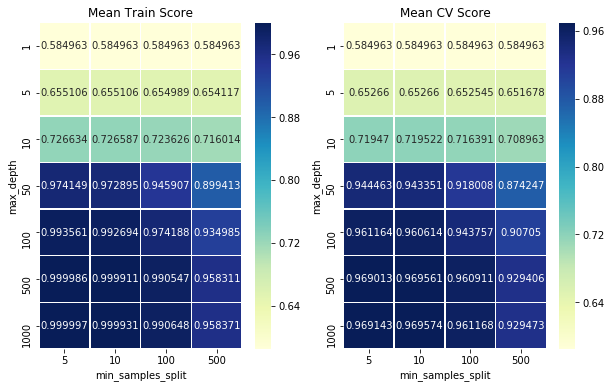

In [4]:
print("Best Hyperparameter for Bag of Words: "+ str(best_hyperparameter_bow))
print("Best Score for Bag of Words: "+ str(best_score_bow))
auc_score_plot(results_bow)

#### Running Decision Tree Classifier on best hyperparameters

In [9]:
dt_classifier(best_estimator_bow, X_tr_bow, y_train_bow, X_test_bow, y_test_bow, 'bow_auc_score.pickle')

#### Opening Decision Tree classifier results

In [9]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('bow_auc_score.pickle', 'rb') as f:
    train_fpr_bow, train_tpr_bow, train_auc_bow, y_train_predict_bow, test_fpr_bow, test_tpr_bow, test_auc_bow, \
    y_test_predict_bow, tree_object_bow = pickle.load(f)

#### Plotting ROC curve

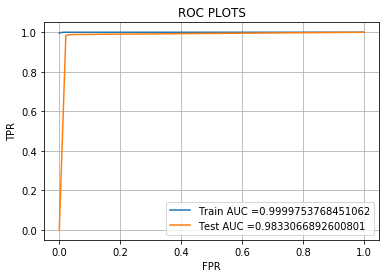

In [10]:
roc_plot(train_fpr_bow, train_tpr_bow, train_auc_bow, test_fpr_bow, test_tpr_bow, test_auc_bow)

#### Train confusion matrix

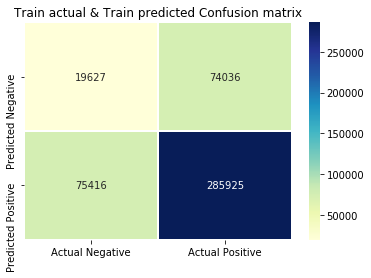

In [11]:
train_conf(y_train_bow, y_train_predict_bow)

#### Test confusion matrix

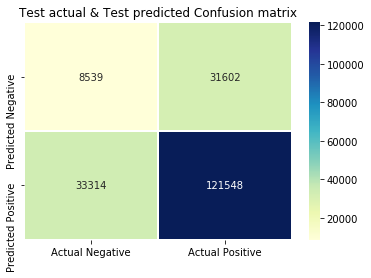

In [12]:
test_conf(y_test_bow, y_test_predict_bow)

#### Extracting False positive points

In [46]:
False_Positive_points_bow = perf_measure(y_test_bow, y_test_predict_bow)

In [48]:
False_Positive_points_bow.head()

id   price                                              essay  \
475505  p066820  149.99  students class come area poverty extremely hig...   
587163  p003305   59.99  young students 3 4 year olds come school half ...   
570282  p228706   44.95  teach 7th grade science high performing ethnic...   
435010  p000248    5.84  students class full energy love run around joy...   
159888  p070048    8.89  class normally read shared text students work ...   

        teacher_number_of_previously_posted_projects  project_is_approved  \
475505                                             0                    1   
587163                                             0                    1   
570282                                             7                    0   
435010                                             4                    0   
159888                                             1                    1   

        y_pred  y_actual  
475505       1         0  
587163       1         0  
570282       1         0  
435010       1         0  
159888       1         0

In [47]:
print(len(False_Positive_points_bow))

31602


#### Probability Density Function plot

/Users/swatisharma/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

/Users/swatisharma/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



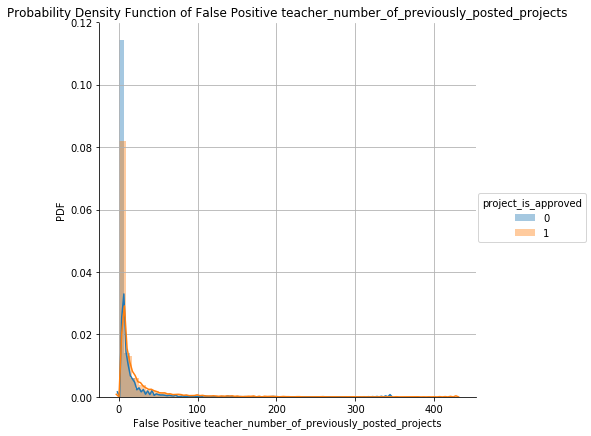

In [50]:
pdf_plot(False_Positive_points_bow)

For both approved and non approved projects, the false positive teacher_number_of_previously_posted_projects lie less than 100 with maximum less than 50.

#### Box plot

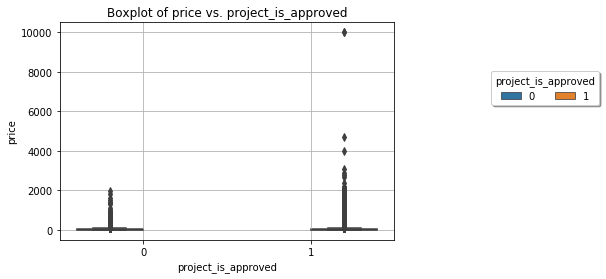

In [15]:
boxplot(False_Positive_points_bow)

Only outliers are observed.

#### Decision Tree

<img src="tree/tree_BOW.png">

#### Word cloud

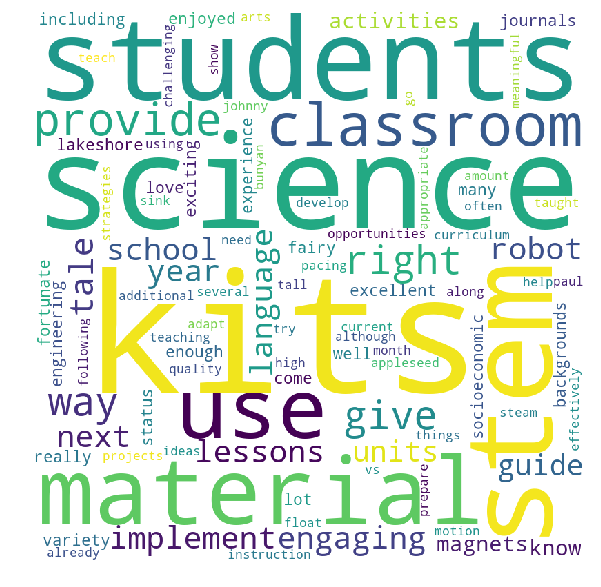

In [6]:
# https://www.geeksforgeeks.org/generating-word-cloud-python/

# Reads 'Youtube04-Eminem.csv' file 
df = pd.read_csv(r"Essay.csv", encoding ="utf-8") 

comment_words = ' '
stopwords = set(STOPWORDS) 

# iterate through the csv file 
for row in df: 
        row = str(row) 
        tokens = row.split() 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 
        for words in tokens: 
            comment_words = comment_words + words + ' '


wordcloud = WordCloud(width = 800, height = 800, \
                      background_color ='white', \
                      stopwords = stopwords, \
                      min_font_size = 10).generate(comment_words) 


plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 


## Set 2 - TFIDF

#### Opening TFIDF variables

In [6]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('tfidf.pickle', 'rb') as f:
    X_tr_tfidf, y_train_tfidf, X_test_tfidf, y_test_tfidf = pickle.load(f)

#### Hyperparameter tuning

In [7]:
hparameter_tuning(X_tr_tfidf, y_train_tfidf, 'tfidf_grid_s_results.pickle')

#### Opening gridsearch results 

In [5]:
# This file stored the gridsearchcv cv_results_ dictionary as a variable into the pickle.

with open('tfidf_grid_s_results.pickle', 'rb') as f:
    results_tfidf, best_hyperparameter_tfidf, best_score_tfidf, best_estimator_tfidf = pickle.load(f)

/Users/swatisharma/anaconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning:

Trying to unpickle estimator DecisionTreeClassifier from version 0.19.2 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.



#### Best Hyperparameter and Score

Best Hyperparameter for TFIDF: {'min_samples_split': 10, 'max_depth': 500}
Best Score for TFIDF: 0.9688787396962081


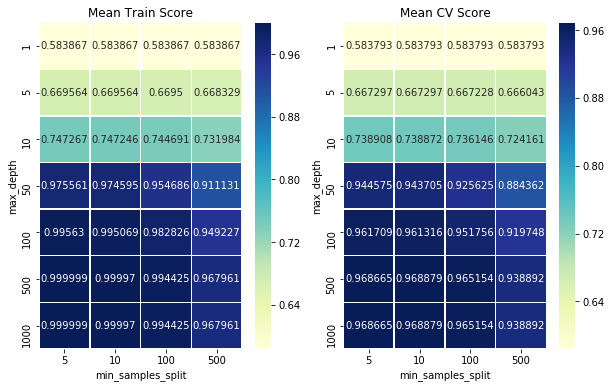

In [6]:
print("Best Hyperparameter for TFIDF: "+ str(best_hyperparameter_tfidf))
print("Best Score for TFIDF: "+ str(best_score_tfidf))
auc_score_plot(results_tfidf)

#### Running Decision Tree classifier for best hyperparameter

In [6]:
dt_classifier(best_estimator_tfidf, X_tr_tfidf, y_train_tfidf, X_test_tfidf, y_test, 'tfidf_auc_score.pickle')

#### Opening Decision Tree classifier's results

In [6]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('tfidf_auc_score.pickle', 'rb') as f:
    train_fpr_tfidf, train_tpr_tfidf, train_auc_tfidf, y_train_predict_tfidf, test_fpr_tfidf, test_tpr_tfidf, \
    test_auc_tfidf, y_test_predict_tfidf, tree_object_tfidf = pickle.load(f)

#### Plotting ROC curve

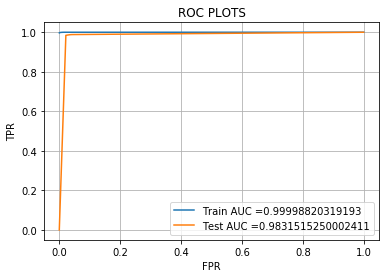

In [7]:
roc_plot(train_fpr_tfidf, train_tpr_tfidf, train_auc_tfidf, test_fpr_tfidf, test_tpr_tfidf, test_auc_tfidf)

#### Train confusion matrix

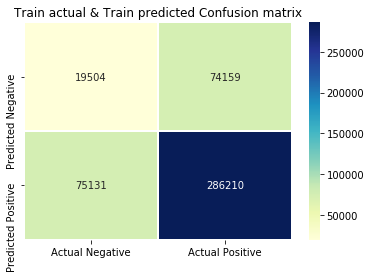

In [11]:
train_conf(y_train_tfidf, y_train_predict_tfidf)

#### Test confusion matrix

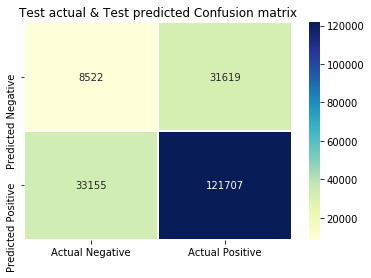

In [12]:
test_conf(y_test_tfidf, y_test_predict_tfidf)

#### Extracting False positive points

In [51]:
False_Positive_points_tfidf = perf_measure(y_test_tfidf, y_test_predict_tfidf)

In [52]:
False_Positive_points_tfidf.head()

id   price                                              essay  \
475505  p066820  149.99  students class come area poverty extremely hig...   
587163  p003305   59.99  young students 3 4 year olds come school half ...   
570282  p228706   44.95  teach 7th grade science high performing ethnic...   
435010  p000248    5.84  students class full energy love run around joy...   
159888  p070048    8.89  class normally read shared text students work ...   

        teacher_number_of_previously_posted_projects  project_is_approved  \
475505                                             0                    1   
587163                                             0                    1   
570282                                             7                    0   
435010                                             4                    0   
159888                                             1                    1   

        y_pred  y_actual  
475505       1         0  
587163       1         0  
570282       1         0  
435010       1         0  
159888       1         0

In [53]:
print(len(False_Positive_points_tfidf))

31619


#### Plotting PDF 

/Users/swatisharma/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

/Users/swatisharma/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



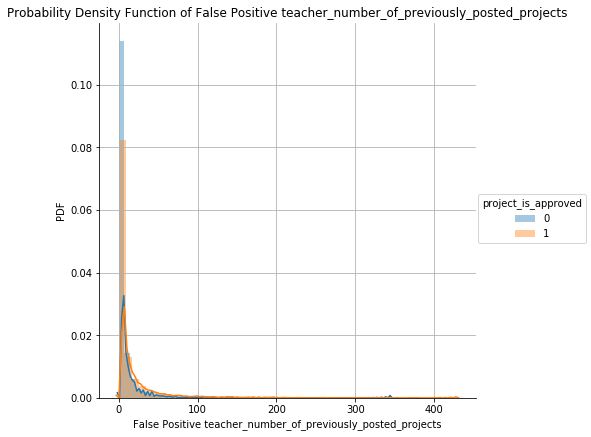

In [54]:
pdf_plot(False_Positive_points_tfidf)

For both approved and non approved projects, the false positive teacher_number_of_previously_posted_projects lie less than 100 with maximum less than 50.

#### Boxplot

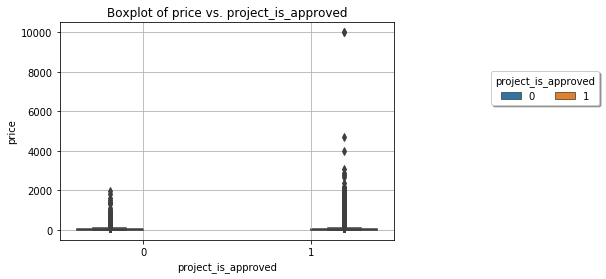

In [21]:
boxplot(False_Positive_points_tfidf)

Only outliers are observed.

#### Decision Tree

<img src="tree/tree_TFIDF.png">

## Set 3 - Avg W2V

#### Opening Avg W2V variables

In [8]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('avgword2vec.pickle', 'rb') as f:
    X_tr_avgw2v, y_train, X_test_avgw2v, y_test = pickle.load(f)

#### Hyperparameter tuning

In [9]:
hparameter_tuning(X_tr_avgw2v, y_train_avgw2v, 'avgword2vec_grid_s_results.pickle')

#### Opening grid search results

In [7]:
# This file stored the gridsearchcv cv_results_ dictionary as a variable into the pickle.

with open('avgword2vec_grid_s_results.pickle', 'rb') as f:
    results_avgword2vec, best_hyperparameter_avgword2vec, best_score_avgword2vec, best_estimator_avgword2vec \
    = pickle.load(f)

/Users/swatisharma/anaconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning:

Trying to unpickle estimator DecisionTreeClassifier from version 0.19.2 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.



#### Best Hyperparameter and score

Best Hyperparameter for Average W2V: {'min_samples_split': 10, 'max_depth': 500}
Best Score for Average W2V: 0.9685186825092922


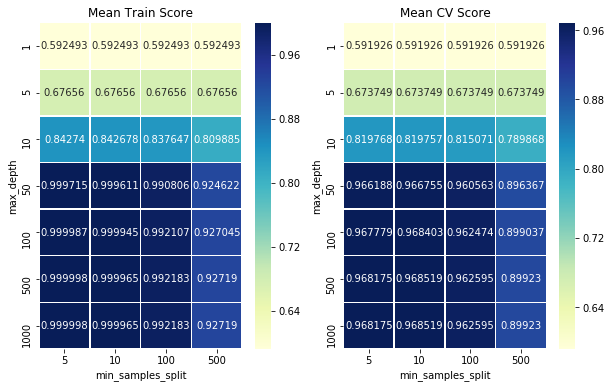

In [8]:
print("Best Hyperparameter for Average W2V: "+ str(best_hyperparameter_avgword2vec))
print("Best Score for Average W2V: "+ str(best_score_avgword2vec))
auc_score_plot(results_avgword2vec)

#### Running Decision tree classifier

In [9]:
dt_classifier(best_estimator_avgword2vec, X_tr_avgw2v, y_train_avgw2v, X_test_avgw2v, y_test_avgw2v, \
              'avgword2vec_auc_score.pickle')

#### Decision Tree classifier's resullts

In [13]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('avgword2vec_auc_score.pickle', 'rb') as f:
    train_fpr_avgword2vec, train_tpr_avgword2vec, train_auc_avgword2vec, y_train_predict_avgword2vec, \
    test_fpr_avgword2vec, test_tpr_avgword2vec, test_auc_avgword2vec, y_test_predict_avgword2vec, \
    tree_object_avgword2vec = pickle.load(f)

#### Plotting ROC curve

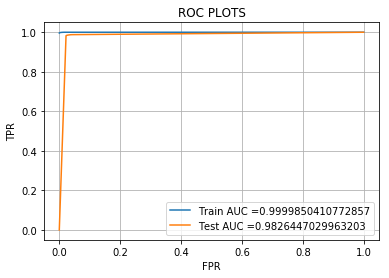

In [14]:
roc_plot(train_fpr_avgword2vec, train_tpr_avgword2vec, train_auc_avgword2vec, \
         test_fpr_avgword2vec, test_tpr_avgword2vec, test_auc_avgword2vec)

#### Train confusion matrix

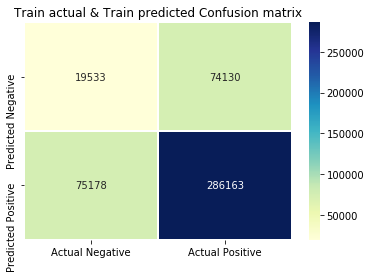

In [15]:
train_conf(y_train_avgw2v, y_train_predict_avgword2vec)

#### Test confusion matrix

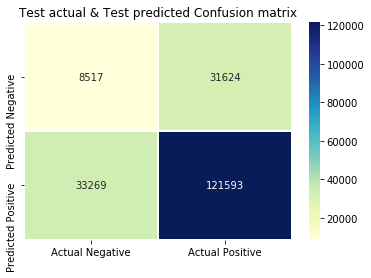

In [16]:
test_conf(y_test_avgw2v, y_test_predict_avgword2vec)

#### Extracting False positive points

In [55]:
False_Positive_points_avgword2vec = perf_measure(y_test_avgword2vec, y_test_predict_avgword2vec)

In [56]:
False_Positive_points_avgword2vec.head()

id   price                                              essay  \
475505  p066820  149.99  students class come area poverty extremely hig...   
587163  p003305   59.99  young students 3 4 year olds come school half ...   
570282  p228706   44.95  teach 7th grade science high performing ethnic...   
435010  p000248    5.84  students class full energy love run around joy...   
159888  p070048    8.89  class normally read shared text students work ...   

        teacher_number_of_previously_posted_projects  project_is_approved  \
475505                                             0                    1   
587163                                             0                    1   
570282                                             7                    0   
435010                                             4                    0   
159888                                             1                    1   

        y_pred  y_actual  
475505       1         0  
587163       1         0  
570282       1         0  
435010       1         0  
159888       1         0

In [57]:
print(len(False_Positive_points_avgword2vec))

31624


#### Plotting PDF

/Users/swatisharma/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

/Users/swatisharma/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



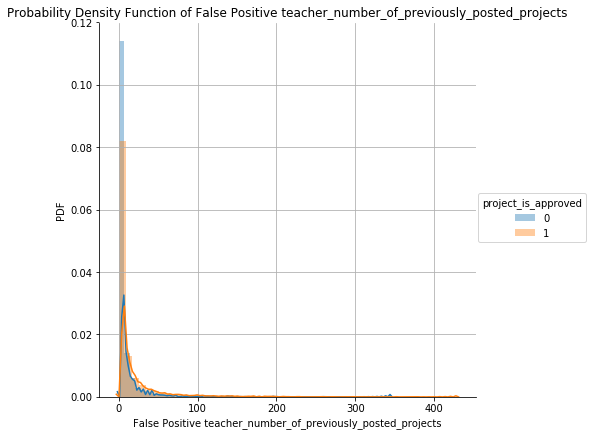

In [58]:
pdf_plot(False_Positive_points_avgword2vec)

For both approved and non approved projects, the false positive teacher_number_of_previously_posted_projects lie less than 100 with maximum less than 50.

#### Boxplot 

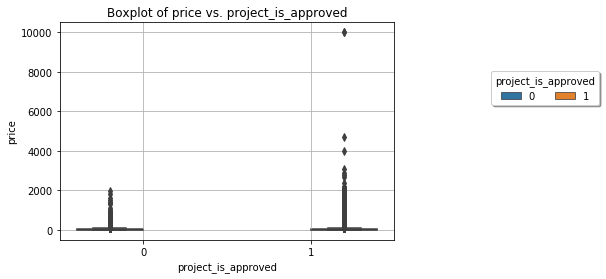

In [24]:
boxplot(False_Positive_points_avgword2vec)

Only outliers are observed.

## Set 4 - TFIDF W2V

#### Opening TFIDF W2V variables

In [10]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('tfidf_w2v.pickle', 'rb') as f:
    X_tr_tfidf_w2v, y_train_tfidf_w2v, X_test_tfidf_w2v, y_test_tfidf_w2v = pickle.load(f)

#### Hyperparameter tuning

In [11]:
hparameter_tuning(X_tr_tfidf_w2v, y_train_tfidf_w2v, 'tfidf_w2v_grid_s_results.pickle')

#### Opening grid search results

In [9]:
# This file stored the gridsearchcv cv_results_ dictionary as a variable into the pickle.

with open('tfidf_w2v_grid_s_results.pickle', 'rb') as f:
    results_tfidf_w2v, best_hyperparameter_tfidf_w2v, best_score_tfidf_w2v, best_estimator_tfidf_w2v \
    = pickle.load(f)

/Users/swatisharma/anaconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning:

Trying to unpickle estimator DecisionTreeClassifier from version 0.19.2 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.



#### Best hyperparameter and score

Best Hyperparameter for TFIDF W2V: {'min_samples_split': 10, 'max_depth': 500}
Best Score for TFIDF W2V: 0.9693811763842815


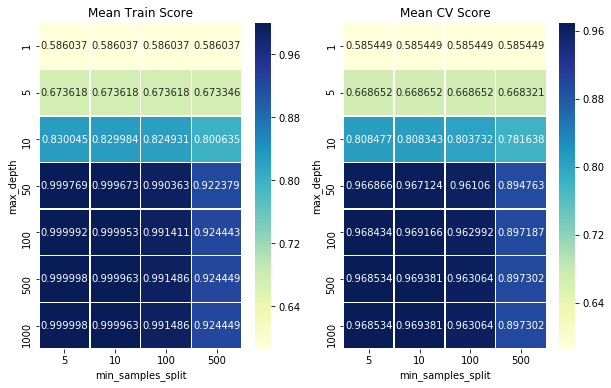

In [10]:
print("Best Hyperparameter for TFIDF W2V: "+ str(best_hyperparameter_tfidf_w2v))
print("Best Score for TFIDF W2V: "+ str(best_score_tfidf_w2v))
auc_score_plot(results_tfidf_w2v)

#### Running Decision tree classifier

In [17]:
dt_classifier(best_estimator_tfidf_w2v, X_tr_tfidf_w2v, y_train_tfidf_w2v, X_test_tfidf_w2v, y_test_tfidf_w2v, \
              'tfidf_w2v_auc_score.pickle')

#### Decision Tree classifier results

In [17]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('tfidf_w2v_auc_score.pickle', 'rb') as f:
    train_fpr_tfidf_w2v, train_tpr_tfidf_w2v, train_auc_tfidf_w2v, y_train_predict_tfidf_w2v, test_fpr_tfidf_w2v, \
    test_tpr_tfidf_w2v, test_auc_tfidf_w2v, y_test_predict_tfidf_w2v, tree_object_tfidf_w2v = pickle.load(f)

#### Plotting ROC curve

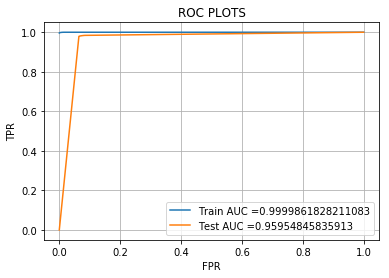

In [18]:
roc_plot(train_fpr_tfidf_w2v, train_tpr_tfidf_w2v, train_auc_tfidf_w2v, \
         test_fpr_tfidf_w2v, test_tpr_tfidf_w2v, test_auc_tfidf_w2v)

#### Train confusion matrix

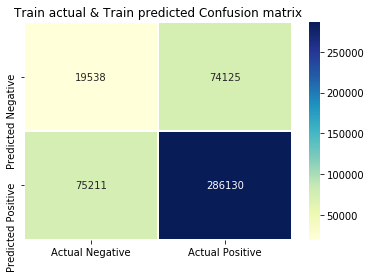

In [19]:
train_conf(y_train_tfidf_w2v, y_train_predict_tfidf_w2v)

#### Test confusion matrix

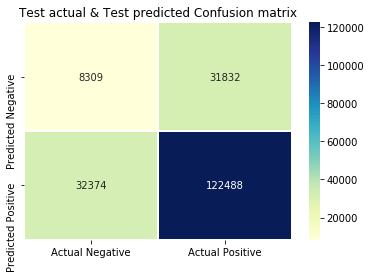

In [20]:
test_conf(y_test_tfidf_w2v, y_test_predict_tfidf_w2v)

#### Extracting False positive points

In [59]:
False_Positive_points_tfidf_w2v = perf_measure(y_test_tfidf_w2v, y_test_predict_tfidf_w2v)

In [60]:
False_Positive_points_tfidf_w2v.head()

id   price                                              essay  \
475505  p066820  149.99  students class come area poverty extremely hig...   
587163  p003305   59.99  young students 3 4 year olds come school half ...   
570282  p228706   44.95  teach 7th grade science high performing ethnic...   
435010  p000248    5.84  students class full energy love run around joy...   
159888  p070048    8.89  class normally read shared text students work ...   

        teacher_number_of_previously_posted_projects  project_is_approved  \
475505                                             0                    1   
587163                                             0                    1   
570282                                             7                    0   
435010                                             4                    0   
159888                                             1                    1   

        y_pred  y_actual  
475505       1         0  
587163       1         0  
570282       1         0  
435010       1         0  
159888       1         0

In [61]:
print(len(False_Positive_points_tfidf_w2v))

31832


#### Plotting PDF

/Users/swatisharma/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

/Users/swatisharma/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



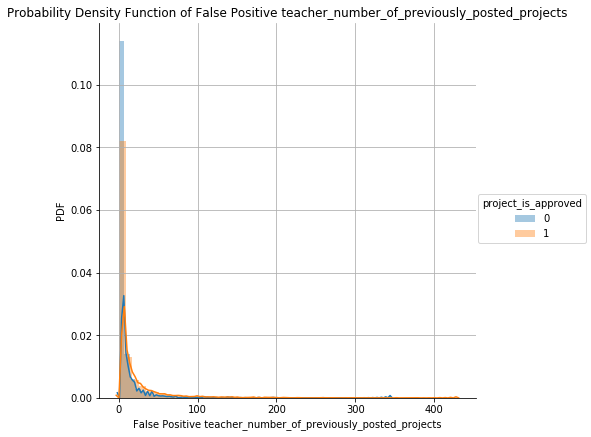

In [62]:
pdf_plot(False_Positive_points_tfidf_w2v)

For both approved and non approved projects, the false positive teacher_number_of_previously_posted_projects lie less than 100 with maximum less than 50.

#### Boxplot

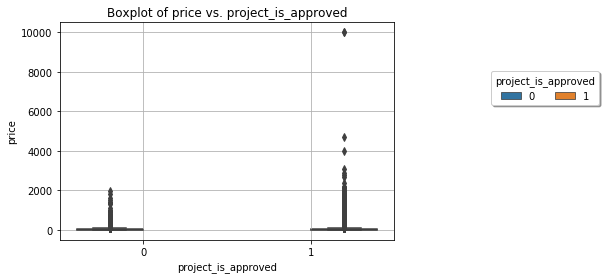

In [27]:
boxplot(False_Positive_points_tfidf_w2v)

Only outliers are observed.

## Set 5 - TFIDF Important 5000 Features

#### Hyperparameter tuning 

In [11]:
hparameter_tuning(X_tr_tfidf, y_train_tfidf, 'set5_grid_s_results.pickle')

#### Opening TFIDF vocab

In [2]:
with open('TFIDF_vocabulary.pickle', 'rb') as f:
    TFIDF_vocab = pickle.load(f)

#### Processing Through the vocab

In [3]:
TFIDF_vocab_arr = np.array(TFIDF_vocab)

In [39]:
index=list()
for i, array in enumerate(TFIDF_vocab_arr):
    index.append(i)

In [14]:
# dict1 keys = 'vocab', values = vocab index

dict1 = dict(zip(TFIDF_vocab_arr, index))

#### Opening 5000 best features

In [16]:
# This file stored the gridsearchcv cv_results_ dictionary as a variable into the pickle.

with open('set5_grid_s_results.pickle', 'rb') as f:
    results_set5, best_hyperparameter_set5, best_score_set5, best_estimator_set5, feature_imp_score_set5 \
    = pickle.load(f)
    

In [17]:
# dict2 keys = 'feat_names', values = score

dict2 = dict(zip(TFIDF_vocab_arr, feature_imp_score_set5))

In [18]:
from collections import OrderedDict
from operator import itemgetter
sorted_dict2 = OrderedDict(sorted(dict2.items(), key = itemgetter(1), reverse = True))


In [26]:
# https://stackoverflow.com/questions/36671496/how-to-get-all-keys-from-ordered-dictionary

sorted_dict2_feature_names = list(sorted_dict2.keys())


In [42]:
top5k_feature_names = sorted_dict2_feature_names[:5000]

In [44]:
# dict3 keys = vocab according to top score keys, values = index of vocab

dict3 = dict((k, dict1[k]) for k in top5k_feature_names)

In [45]:
top5k_feature_index = list(dict3.values())

#### Storing best 5000 features

In [48]:
with open('set5_imp_feature_dataset.pickle', 'wb') as f:
            pickle.dump([X_tr_tfidf[:,top5k_feature_index], y_train_tfidf, \
                         X_test_tfidf[:,top5k_feature_index], y_test_tfidf] , f)
        

In [3]:
with open('set5_imp_feature_dataset.pickle', 'rb') as f:
    X_tr_set5, y_train_set5, X_test_set5, y_test_set5 = pickle.load(f)

#### Running decision tree classifier on best 5000 features and hyperparameters of it

In [4]:
dt = DecisionTreeClassifier(class_weight ='balanced')
clf = GridSearchCV(estimator=dt, param_grid=parameters, cv=3, scoring='roc_auc', n_jobs=-1)
clf.fit(X_tr_set5, y_train_set5)
results = clf.cv_results_
best_hyperparameter = clf.best_params_
best_score = clf.best_score_
best_estimator = clf.best_estimator_

with open('set5_grid_s_results_on_imp_features.pickle', 'wb') as f:
    pickle.dump([results, best_hyperparameter, best_score, best_estimator] , f)
    
    

In [4]:
# This file stored the gridsearchcv cv_results_ dictionary as a variable into the pickle.

with open('set5_grid_s_results_on_imp_features.pickle', 'rb') as f:
    results_set5, best_hyperparameter_set5, best_score_set5, best_estimator_set5 = pickle.load(f)

/Users/swatisharma/anaconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning:

Trying to unpickle estimator DecisionTreeClassifier from version 0.19.2 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.



#### Best hyperparameters of 5000 best features and score

Best Hyperparameter for TFIDF(Top 5k features): {'min_samples_split': 10, 'max_depth': 1000}
Best Score for TFIDF(Top 5k features): 0.9688792122871163


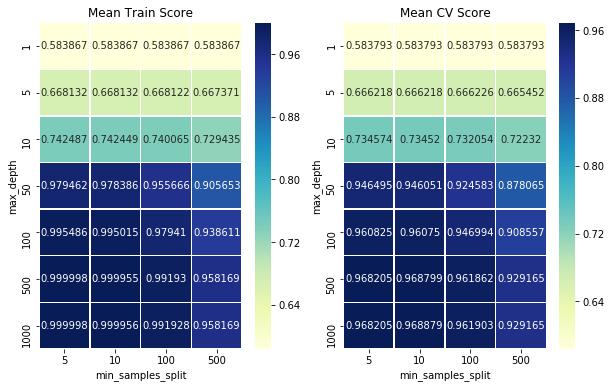

In [5]:
print("Best Hyperparameter for TFIDF(Top 5k features): "+ str(best_hyperparameter_set5))
print("Best Score for TFIDF(Top 5k features): "+ str(best_score_set5))
auc_score_plot(results_set5)

#### Running Decision tree classifier on best 5000 feature hyperparameter

In [ ]:
dt_classifier(best_estimator_imp_feat_set5, X_tr_imp_feat_set5, y_train, X_test_imp_feat_set5, y_test, \
              'set5_auc_score.pickle')

In [6]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('set5_auc_score.pickle', 'rb') as f:
    train_fpr_set5, train_tpr_set5, train_auc_set5, y_train_predict_set5, test_fpr_set5, test_tpr_set5, \
    test_auc_set5, y_test_predict_set5, tree_object_set5 = pickle.load(f)

#### ROC curve

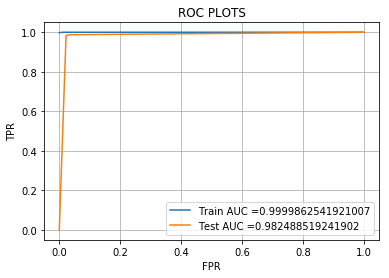

In [7]:
roc_plot(train_fpr_set5, train_tpr_set5, train_auc_set5, test_fpr_set5, test_tpr_set5, test_auc_set5)

#### Train confusion matrix

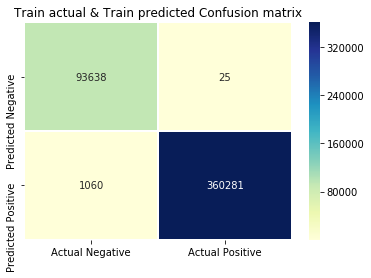

In [8]:
train_conf(y_tr_set5, y_train_predict_set5)

#### Test confusion matrix

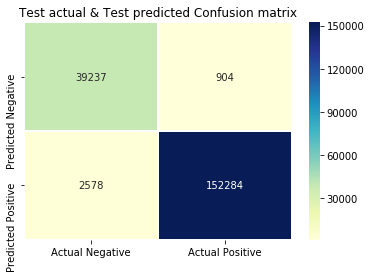

In [9]:
test_conf(y_test_set5, y_test_predict_set5)

#### Extracting false positive points

In [10]:
False_Positive_points_set5 = perf_measure(y_test_set5, y_test_predict_set5)

In [11]:
False_Positive_points_set5.head()

id  price                                              essay  \
569305  p181797   7.00  tenth grade students recent immigrants learnin...   
110357  p166968  12.20  19 amazing students small community surroundin...   
447179  p240659   9.59  students teach highly motivated learn school s...   
223825  p078734  11.24  unique special little tigers k 5 elementary sc...   
617835  p109735   8.68  students energetic learners curious world arou...   

        teacher_number_of_previously_posted_projects  project_is_approved  \
569305                                            16                    1   
110357                                             0                    1   
447179                                             4                    0   
223825                                             5                    1   
617835                                             4                    1   

        y_pred  y_actual  
569305       1         0  
110357       1         0  
447179       1         0  
223825       1         0  
617835       1         0

In [12]:
print(len(False_Positive_points_set5))

904


#### PDF plot

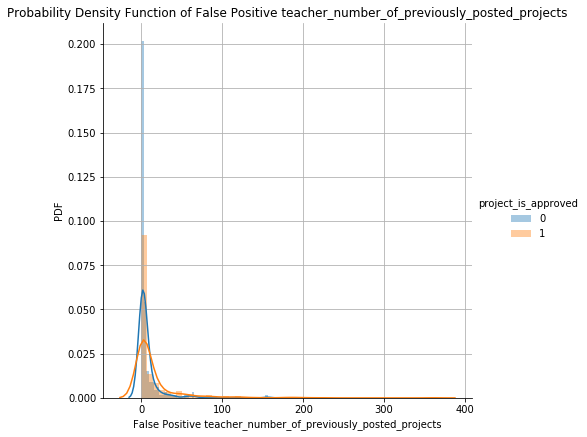

In [13]:
pdf_plot(False_Positive_points_set5)

For both approved and non approved projects, the false positive teacher_number_of_previously_posted_projects lie between negative to 100 with peak at 0.

#### Box plot

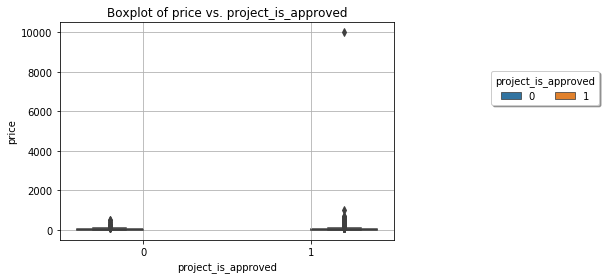

In [8]:
boxplot(False_Positive_points_set5)

Only outliers are observed.

# Conclusion

In [5]:
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "min_samples_split", "max_depth", "Best Score", "Train AUC", "Test AUC"]
x.add_row(['BOW', 'Decision Tree Classifier', 10, 1000, 0.9695, 0.9999, 0.9833])
x.add_row(['TFIDF', 'Decision Tree Classifier',10, 500, 0.9688, 0.9999, 0.9831])
x.add_row(['Avg W2V', 'Decision Tree Classifier',10, 500, 0.9685, 0.9999, 0.9826])
x.add_row(['TFIDF W2V', 'Decision Tree Classifier',10, 500, 0.9693, 0.9999, 0.9595])
x.add_row(['Set5', 'Best 5000 features of TFIDF',10, 1000, 0.9688, 0.9999, 0.9824])
print(x)

+------------+-----------------------------+-------------------+-----------+------------+-----------+----------+
| Vectorizer |            Model            | min_samples_split | max_depth | Best Score | Train AUC | Test AUC |
+------------+-----------------------------+-------------------+-----------+------------+-----------+----------+
|    BOW     |   Decision Tree Classifier  |         10        |    1000   |   0.9695   |   0.9999  |  0.9833  |
|   TFIDF    |   Decision Tree Classifier  |         10        |    500    |   0.9688   |   0.9999  |  0.9831  |
|  Avg W2V   |   Decision Tree Classifier  |         10        |    500    |   0.9685   |   0.9999  |  0.9826  |
| TFIDF W2V  |   Decision Tree Classifier  |         10        |    500    |   0.9693   |   0.9999  |  0.9595  |
|    Set5    | Best 5000 features of TFIDF |         10        |    1000   |   0.9688   |   0.9999  |  0.9824  |
+------------+-----------------------------+-------------------+-----------+------------+-------

# Summary

For Gridsearch results of Decision Tree Classifier, best hyperparameter min_samples_split came out to be 10 for all the sets. Best hyperparameter max_depth came out to be 1000 for Bag of Words and TFIDF best 5000 features and 500 for TFIDF, Avg W2V and TFIDF W2V. 

Best score of best hyperparameter grid search for Bag of Words 0.9695, for TFIDF 0.9688, for Avg W2V 0.9685, for TFIDF W2V 0.9693 and for set 5 0.9688.

For Decision Tree Classifier prediction, Train AUC for all the sets was 0.9999 and Test AUC for Bag of Words was 0.9833, for TFIDF 0.9831, for Avg W2V 0.9826, for TFIDF W2V 0.9895 and for set 5 0.9824.